In [1]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-1m'

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import sklearn
import torch
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [3]:
[df, df_train,df_valid,df,df_ratings,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/reads.pkl','rb'))

## Dataset and DataLoader

In [4]:
df_train.shape,df_valid.shape

((6041, 3707), (6041, 3707))

In [5]:
df_train[1]

<1x3707 sparse matrix of type '<class 'numpy.int64'>'
	with 95 stored elements in Compressed Sparse Row format>

In [6]:
df_train[1].todense().shape

(1, 3707)

In [7]:
df_train[1].todense().getA1().shape

(3707,)

In [8]:
class autoencdata (Dataset):
    def __init__(self,dfX,dfXv):
        self.dfX,self.dfXv=dfX,dfXv
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX[idx].todense().getA1()),torch.FloatTensor(self.dfXv[idx].todense().getA1())

In [9]:
dstrain=autoencdata(df_train, df_valid)
#dsvalid=autoencdata(df_valid)

In [81]:
bs=32

In [82]:
# Create a DataLoader object
dltrain=DataLoader(dstrain,batch_size=bs,shuffle=True)
#dlvalid=DataLoader(dsvalid,batch_size=bs,shuffle=False) 

In [18]:
df_train.min(),df_train.max()

(0, 5)

In [19]:
df_train.shape

(6041, 3707)

In [20]:
len(dltrain)

189

In [21]:
df_train.shape

(6041, 3707)

In [22]:
# 6041 users

## Create the Model Architecture for the Encoder

In [92]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout),
        nn.BatchNorm1d(y)
        )   

In [93]:
class autoencoder (nn.Module):    
    def __init__(self,n_inp=9724,hidden=[50,10],dropouts=[0,0,0],rating_range=[0.5,5]):
        super().__init__()
        self.n_inp,self.hidden,self.dropouts,self.rating_range=n_inp,hidden,dropouts,rating_range
        encoder=[hidden_layer(n_inp if i==0 else hidden[i-1],hidden[i],dropouts[i],\
                              nn.Sigmoid() if i<len(hidden)-1 else nn.Sigmoid()) for i in range(len(hidden))]
        self.encoder=nn.Sequential(*encoder)
        hidden=hidden[::-1]
        num_steps=len(hidden)-1
        dropouts=dropouts[num_steps:]
        decoder=[hidden_layer(hidden[i],hidden[i+1] if i<len(hidden)-1 else n_inp,dropouts[i]) for i in range(len(hidden)-1)]
        self.decoder=nn.Sequential(*decoder)
        self.fc=nn.Linear(hidden[-1],n_inp)
        self.initialize()
        self.criterion=nn.MSELoss()
    
    def initialize(self):
        for x in self.encoder:
            nn.init.kaiming_normal_(x[0].weight.data)
        for x in self.decoder:
            nn.init.kaiming_normal_(x[0].weight.data)

    def forward (self,Xb):
        encoded=self.encoder(Xb)
        decoded=self.decoder(encoded)
        out=self.fc(decoded)
        outv=out.clone()
        out[Xb==0]=0
        loss=self.criterion(out,Xb)
        return outv,loss, out

In [94]:
n_final_user=10 # 3 for IMDB

In [95]:
autoenc=autoencoder(df_train.shape[1],[25,n_final_user],[0.2,0.2,0.2])

In [96]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3707, out_features=25, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.2)
      (3): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Linear(in_features=25, out_features=10, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.2)
      (3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=25, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.2)
      (3): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (fc): Linear(in_features=25, out_features=3707, bias=True)
  (criterion): MSELoss()
)

In [34]:
for Xb,Xb_v in dltrain:
    print (Xb)
    break

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 5.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 4.,  ..., 0., 0., 0.]])


In [35]:
Xb.size()

torch.Size([32, 3707])

In [36]:
Xb.squeeze(0)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 5.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 4.,  ..., 0., 0., 0.]])

In [37]:
preds,loss,_=autoenc.forward(Xb)

In [38]:
loss.backward()

In [39]:
preds.size()

torch.Size([32, 3707])

In [40]:
nn.MSELoss

torch.nn.modules.loss.MSELoss

In [41]:
device="cuda:1"

In [42]:
wd=1e-7
#wd=1e-1

In [43]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
#optimizer=torch.optim.SGD(model_sentiment.parameters(),lr=1e-2,momentum=0.9, weight_decay=wd)
metric_fn=None

In [44]:
len(dltrain)

189

In [45]:
import matplotlib.pyplot as plt

In [46]:
dltrain.batch_size

32

In [47]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        
    def fit (self,Xb,Xb_v,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss,preds_train=self.model(Xb)
        # denominator is the average of the error with non-zero ratings

        mean_corrector = Xb.size(0)*Xb.size(1)/(torch.sum(Xb > 0).float() + 1e-10)
        mean_corrector_v = Xb_v.size(0)*Xb_v.size(1)/(torch.sum(Xb_v > 0).float() + 1e-10)

        with torch.no_grad():
            
            preds[Xb_v==0]=0
            loss_v=self.model.criterion(preds,Xb_v)
            
            if self.metric_fn is not None:
                acc=self.metric_fn(preds,Yb.view(-1),self.device)
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc=0
                acc_v=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=torch.sqrt(loss.item()*mean_corrector)
        myloss_v=torch.sqrt(loss_v.item()*mean_corrector_v)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc,myloss_v,acc_v
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_loss_v,epoch_acc_v=0,0

        for Xb,Xb_v in iterator:
            Xb=Xb.to(self.device)
            Xb_v=Xb_v.to(self.device)
            #Xb=Xb.squeeze(0)
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc,loss_v,acc_v=self.fit(Xb,Xb_v,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            epoch_loss+=loss
            epoch_acc+=acc
            epoch_loss_v+=loss_v
            epoch_acc_v+=acc_v
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)} {epoch_loss_v/(k)} ')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_loss_v=epoch_loss_v/len(iterator)
        epoch_acc_v=epoch_acc_v/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_loss_v,epoch_acc_v
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):
        
        
            
        
        for epoch in range(n_epochs):                

            loss,acc,lossv,accv=self.run_epoch(dltrain,True)
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss}  Valid Loss:{lossv} ')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [51]:
autoenc=autoencoder(df_train.shape[1],[n_final_user*4,n_final_user],[0.2,0.2,0.2]).to(device)
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)

In [52]:
learner=Learner(autoenc,optimizer,None,device,0,500,0.25,cycle_mult=0)

In [53]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3707, out_features=40, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=40, out_features=10, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.2)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=40, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.2)
    )
  )
  (fc): Linear(in_features=40, out_features=3707, bias=True)
  (criterion): MSELoss()
)

In [54]:
len(dltrain),dltrain.batch_size

(189, 32)

In [55]:
learner.lr_find(1e-4,3e-1,dltrain,len(dltrain))

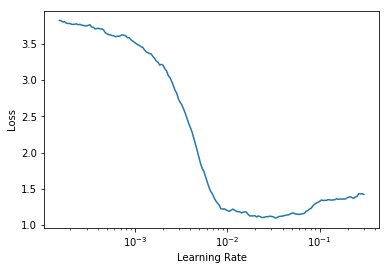

In [56]:
learner.plot_lrs(10)

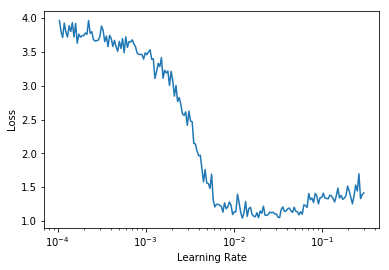

In [57]:
learner.plot_lrs(1)

In [58]:
del autoenc
torch.cuda.empty_cache()

In [59]:
n_final_user

10

In [60]:
#autoenc=autoencoder(df_train.shape[1],[n_final_user*4,n_final_user],[0,0,0])

In [97]:
autoenc=autoencoder(df_train.shape[1],[n_final_user*4,n_final_user],[0.2,0.2,0.2]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=7e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0,start_lr=1e-1,end_lr=5e-2)

In [98]:
learner.run_epochs(dltrain,None,5)

Epoch:0 Learning rate 0.007 Weight Decay 1e-07 Train Loss:1.5444715023040771  Valid Loss:1.5543502569198608 
Epoch:1 Learning rate 0.007 Weight Decay 1e-07 Train Loss:1.002166986465454  Valid Loss:1.0008893013000488 
Epoch:2 Learning rate 0.007 Weight Decay 1e-07 Train Loss:0.995646059513092  Valid Loss:0.9936838746070862 
Epoch:3 Learning rate 0.007 Weight Decay 1e-07 Train Loss:0.9930841326713562  Valid Loss:0.9919650554656982 
Epoch:4 Learning rate 0.007 Weight Decay 1e-07 Train Loss:0.9934859871864319  Valid Loss:0.9937412738800049 


In [99]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=7e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=2,start_lr=7e-3,end_lr=5e-4)

In [100]:
learner.run_epochs(dltrain,None,15)

Epoch:0 Learning rate 0.007 Weight Decay 1e-07 Train Loss:0.9950498938560486  Valid Loss:0.9957966208457947 
Epoch:1 Learning rate 0.0018708286933869708 Weight Decay 1e-07 Train Loss:0.9738324284553528  Valid Loss:0.9736164808273315 
Epoch:2 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:0.9653900265693665  Valid Loss:0.9686646461486816 
Epoch:3 Learning rate 0.007 Weight Decay 1e-07 Train Loss:0.9845552444458008  Valid Loss:0.9840047955513 
Epoch:4 Learning rate 0.0036188120777001943 Weight Decay 1e-07 Train Loss:0.971570611000061  Valid Loss:0.9718353748321533 
Epoch:5 Learning rate 0.0018708286933869708 Weight Decay 1e-07 Train Loss:0.9648833870887756  Valid Loss:0.9669659733772278 
Epoch:6 Learning rate 0.0009671682101338347 Weight Decay 1e-07 Train Loss:0.9583854675292969  Valid Loss:0.960496723651886 
Epoch:7 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:0.955618143081665  Valid Loss:0.9593086838722229 
Epoch:8 Learning rate 0.007 Weight Decay 1e-07 Train Loss:0.97687178

In [101]:
learner.run_epochs(dltrain,None,31)

Epoch:0 Learning rate 0.0006954021175312295 Weight Decay 1e-07 Train Loss:0.9510655999183655  Valid Loss:0.9563114047050476 
Epoch:1 Learning rate 0.0005000000000000003 Weight Decay 1e-07 Train Loss:0.9497909545898438  Valid Loss:0.9562686085700989 
Epoch:2 Learning rate 0.007 Weight Decay 1e-07 Train Loss:0.9678131341934204  Valid Loss:0.9699851870536804 
Epoch:3 Learning rate 0.005935605625791206 Weight Decay 1e-07 Train Loss:0.9679036140441895  Valid Loss:0.9703188538551331 
Epoch:4 Learning rate 0.005033059163560603 Weight Decay 1e-07 Train Loss:0.967369794845581  Valid Loss:0.9692065119743347 
Epoch:5 Learning rate 0.004267750612310043 Weight Decay 1e-07 Train Loss:0.9617438316345215  Valid Loss:0.9637300968170166 
Epoch:6 Learning rate 0.003618812077700194 Weight Decay 1e-07 Train Loss:0.9609230756759644  Valid Loss:0.9661747813224792 
Epoch:7 Learning rate 0.003068548761011205 Weight Decay 1e-07 Train Loss:0.9561874866485596  Valid Loss:0.9591677784919739 
Epoch:8 Learning rate 

In [103]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=1e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0,start_lr=1e-1,end_lr=5e-2)
learner.run_epochs(dltrain,None,31)

Epoch:0 Learning rate 0.001 Weight Decay 1e-07 Train Loss:0.9431902766227722  Valid Loss:0.952446460723877 
Epoch:1 Learning rate 0.001 Weight Decay 1e-07 Train Loss:0.9365893006324768  Valid Loss:0.9474843740463257 
Epoch:2 Learning rate 0.001 Weight Decay 1e-07 Train Loss:0.934906542301178  Valid Loss:0.9458240270614624 
Epoch:3 Learning rate 0.001 Weight Decay 1e-07 Train Loss:0.9338083863258362  Valid Loss:0.9437755942344666 
Epoch:4 Learning rate 0.001 Weight Decay 1e-07 Train Loss:0.9319905638694763  Valid Loss:0.9444485306739807 
Epoch:5 Learning rate 0.001 Weight Decay 1e-07 Train Loss:0.9281965494155884  Valid Loss:0.9406331181526184 
Epoch:6 Learning rate 0.001 Weight Decay 1e-07 Train Loss:0.927833080291748  Valid Loss:0.9388197064399719 
Epoch:7 Learning rate 0.001 Weight Decay 1e-07 Train Loss:0.9300311803817749  Valid Loss:0.9409380555152893 
Epoch:8 Learning rate 0.001 Weight Decay 1e-07 Train Loss:0.9262545108795166  Valid Loss:0.9402275681495667 
Epoch:9 Learning rate 

In [104]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=1e-3,betas=(0.9,0.999), weight_decay=1e-6)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0,start_lr=1e-1,end_lr=5e-2)
learner.run_epochs(dltrain,None,31)

Epoch:0 Learning rate 0.001 Weight Decay 1e-06 Train Loss:0.9153982400894165  Valid Loss:0.9308962225914001 
Epoch:1 Learning rate 0.001 Weight Decay 1e-06 Train Loss:0.9140071868896484  Valid Loss:0.9305980205535889 
Epoch:2 Learning rate 0.001 Weight Decay 1e-06 Train Loss:0.9147056937217712  Valid Loss:0.9299253225326538 
Epoch:3 Learning rate 0.001 Weight Decay 1e-06 Train Loss:0.9146891236305237  Valid Loss:0.9302049875259399 
Epoch:4 Learning rate 0.001 Weight Decay 1e-06 Train Loss:0.913002610206604  Valid Loss:0.9288424253463745 
Epoch:5 Learning rate 0.001 Weight Decay 1e-06 Train Loss:0.9135340452194214  Valid Loss:0.9283024072647095 
Epoch:6 Learning rate 0.001 Weight Decay 1e-06 Train Loss:0.9130706787109375  Valid Loss:0.9293491244316101 
Epoch:7 Learning rate 0.001 Weight Decay 1e-06 Train Loss:0.9131229519844055  Valid Loss:0.9297102093696594 
Epoch:8 Learning rate 0.001 Weight Decay 1e-06 Train Loss:0.9122061729431152  Valid Loss:0.9282559156417847 
Epoch:9 Learning rat

In [106]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=1e-3,betas=(0.9,0.999), weight_decay=1e-6)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0,start_lr=1e-1,end_lr=5e-2)
learner.run_epochs(dltrain,None,64)

Epoch:0 Learning rate 0.001 Weight Decay 1e-06 Train Loss:0.917055070400238  Valid Loss:0.9278200268745422 
Epoch:1 Learning rate 0.001 Weight Decay 1e-06 Train Loss:0.9119176864624023  Valid Loss:0.9232094883918762 
Epoch:2 Learning rate 0.001 Weight Decay 1e-06 Train Loss:0.9112654328346252  Valid Loss:0.922114908695221 
Epoch:3 Learning rate 0.001 Weight Decay 1e-06 Train Loss:0.9109389185905457  Valid Loss:0.9235572218894958 
Epoch:4 Learning rate 0.001 Weight Decay 1e-06 Train Loss:0.9103987216949463  Valid Loss:0.9232545495033264 
Epoch:5 Learning rate 0.001 Weight Decay 1e-06 Train Loss:0.9056656956672668  Valid Loss:0.9183350205421448 
Epoch:6 Learning rate 0.001 Weight Decay 1e-06 Train Loss:0.9061340093612671  Valid Loss:0.9198451638221741 
Epoch:7 Learning rate 0.001 Weight Decay 1e-06 Train Loss:0.9060786366462708  Valid Loss:0.9210558533668518 
Epoch:8 Learning rate 0.001 Weight Decay 1e-06 Train Loss:0.9032335877418518  Valid Loss:0.9155929684638977 
Epoch:9 Learning rate

In [107]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=7e-4,betas=(0.9,0.999), weight_decay=1e-6)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0,start_lr=1e-1,end_lr=5e-2)
learner.run_epochs(dltrain,None,100)

Epoch:0 Learning rate 0.0007 Weight Decay 1e-06 Train Loss:0.8885214328765869  Valid Loss:0.9098312854766846 
Epoch:1 Learning rate 0.0007 Weight Decay 1e-06 Train Loss:0.8867849111557007  Valid Loss:0.9087008833885193 
Epoch:2 Learning rate 0.0007 Weight Decay 1e-06 Train Loss:0.8851664662361145  Valid Loss:0.9070160388946533 
Epoch:3 Learning rate 0.0007 Weight Decay 1e-06 Train Loss:0.885979175567627  Valid Loss:0.9071924090385437 
Epoch:4 Learning rate 0.0007 Weight Decay 1e-06 Train Loss:0.885290265083313  Valid Loss:0.9082332253456116 
Epoch:5 Learning rate 0.0007 Weight Decay 1e-06 Train Loss:0.8859005570411682  Valid Loss:0.909111499786377 
Epoch:6 Learning rate 0.0007 Weight Decay 1e-06 Train Loss:0.8841961026191711  Valid Loss:0.9063416123390198 
Epoch:7 Learning rate 0.0007 Weight Decay 1e-06 Train Loss:0.8863221406936646  Valid Loss:0.9091119766235352 
Epoch:8 Learning rate 0.0007 Weight Decay 1e-06 Train Loss:0.8846147060394287  Valid Loss:0.9079487323760986 
Epoch:9 Learn

Epoch:75 Learning rate 0.0007 Weight Decay 1e-06 Train Loss:0.8801370859146118  Valid Loss:0.9058658480644226 
Epoch:76 Learning rate 0.0007 Weight Decay 1e-06 Train Loss:0.8820619583129883  Valid Loss:0.9068834185600281 
Epoch:77 Learning rate 0.0007 Weight Decay 1e-06 Train Loss:0.8807319402694702  Valid Loss:0.9058859348297119 
Epoch:78 Learning rate 0.0007 Weight Decay 1e-06 Train Loss:0.8801190257072449  Valid Loss:0.906078577041626 
Epoch:79 Learning rate 0.0007 Weight Decay 1e-06 Train Loss:0.879687488079071  Valid Loss:0.9043372869491577 
Epoch:80 Learning rate 0.0007 Weight Decay 1e-06 Train Loss:0.8799718618392944  Valid Loss:0.9055473208427429 
Epoch:81 Learning rate 0.0007 Weight Decay 1e-06 Train Loss:0.879746675491333  Valid Loss:0.9045162200927734 
Epoch:82 Learning rate 0.0007 Weight Decay 1e-06 Train Loss:0.8789826035499573  Valid Loss:0.9043486714363098 
Epoch:83 Learning rate 0.0007 Weight Decay 1e-06 Train Loss:0.8804485201835632  Valid Loss:0.9040932059288025 
Epoc

In [108]:
torch.save(autoenc,f=f'{DATAPATH}/inter/user_autoenc')
torch.save(learner,f=f'{DATAPATH}/inter/user_autoenc_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/user_autoenc_optimizer')
torch.save(autoenc.state_dict(),f'{DATAPATH}/inter/user_autoenc_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/user_autoenc_optimizer_state_dict')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [109]:
autoenc.encoder[0][0].weight.data.shape

torch.Size([40, 3707])

In [110]:
autoenc.encoder[1][0].weight.data.shape

torch.Size([10, 40])

In [111]:
user_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
user_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [112]:
from scipy.special import expit

df_train_user_autoenc=np.tanh(expit(df_train@user_mtx_1_weights.T)@user_mtx_2_weights.T)
df_valid_user_autoenc=np.tanh(expit(df_valid@user_mtx_1_weights.T)@user_mtx_2_weights.T)

In [128]:
df_train_user_autoenc=(expit(df_train@user_mtx_1_weights.T)@user_mtx_2_weights.T)
df_valid_user_autoenc=(expit(df_valid@user_mtx_1_weights.T)@user_mtx_2_weights.T)

In [129]:
df_train_user_autoenc_linear=((df_train@user_mtx_1_weights.T)@user_mtx_2_weights.T)
df_valid_user_autoenc_linear=((df_valid@user_mtx_1_weights.T)@user_mtx_2_weights.T)

In [130]:
df_train_user_autoenc.shape,df_valid_user_autoenc.shape

((6041, 10), (6041, 10))

In [131]:
df_train_user_autoenc=pd.DataFrame(df_train_user_autoenc)
df_train_user_autoenc_linear=pd.DataFrame(df_train_user_autoenc_linear)

In [132]:
df_train_user_autoenc.columns=['user_autoenc'+str(i) for i in range(df_train_user_autoenc.shape[1])]
df_train_user_autoenc_linear.columns=['user_autoenc_linear'+str(i) for i in range(df_train_user_autoenc_linear.shape[1])]

In [133]:
df_valid_user_autoenc=pd.DataFrame(df_valid_user_autoenc)
df_valid_user_autoenc_linear=pd.DataFrame(df_valid_user_autoenc_linear)

In [134]:
df_valid_user_autoenc.columns=['user_autoenc'+str(i) for i in range(df_valid_user_autoenc.shape[1])]
df_valid_user_autoenc_linear.columns=['user_autoenc_linear'+str(i) for i in range(df_valid_user_autoenc_linear.shape[1])]

In [135]:
df_train_user_autoenc.reset_index(inplace=True)
df_valid_user_autoenc.reset_index(inplace=True)
df_train_user_autoenc_linear.reset_index(inplace=True)
df_valid_user_autoenc_linear.reset_index(inplace=True)

In [136]:
df_train_user_autoenc.rename({'index':'user_idx'},axis=1,inplace=True)
df_train_user_autoenc_linear.rename({'index':'user_idx'},axis=1,inplace=True)

In [137]:
df_valid_user_autoenc.rename({'index':'user_idx'},axis=1,inplace=True)
df_valid_user_autoenc_linear.rename({'index':'user_idx'},axis=1,inplace=True)

In [138]:
df_train_user_autoenc.head(),df_train_user_autoenc_linear.head()

(   user_idx  user_autoenc0  user_autoenc1  user_autoenc2  user_autoenc3  \
 0         0      -0.918095       2.296391       0.263371      -0.011968   
 1         1      -1.694891      -0.151930       1.124974      -1.841133   
 2         2       0.807896      -1.376931       0.162299       0.080092   
 3         3      -0.736317      -0.517018       1.213105      -1.961564   
 4         4      -1.399151       0.328619      -1.665964      -1.062431   
 
    user_autoenc4  user_autoenc5  user_autoenc6  user_autoenc7  user_autoenc8  \
 0      -0.804040      -0.389131       0.454120      -3.545166       2.439914   
 1      -2.112378      -1.080319       1.374260      -2.909504      -0.340611   
 2       0.537038       0.585960      -0.161436       1.048445      -1.035838   
 3      -1.423592      -1.065770       0.938449      -1.570770      -0.542528   
 4      -0.760788       0.939962      -1.311538      -0.389501       0.414060   
 
    user_autoenc9  
 0       1.331096  
 1      -1.397

In [146]:
import pickle
pickle.dump([df_train_user_autoenc,df_valid_user_autoenc,user_mtx_1_weights,user_mtx_2_weights,df_train_user_autoenc_linear,df_valid_user_autoenc_linear],open(f'{DATAPATH}/inter/user_autoenc_weights.pkl','wb'))

In [147]:
#,df_train_user_autoenc_linear,df_valid_user_autoenc_linear

In [148]:
autoenc.encoder

Sequential(
  (0): Sequential(
    (0): Linear(in_features=3707, out_features=40, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.2)
    (3): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Linear(in_features=40, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.2)
    (3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [149]:
df_train_user_autoenc.shape

(6041, 11)